# Machine Learning in Python - Project 1

Due Friday, March 8th by 4 pm.

*Pablo Denis González de Vega, Mary O'Brien, Dexter Black, Nikita Jegorovs*

## Setup

*Install any packages here and load data*

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import f_regression, SelectKBest

# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. European Union, Governments, Health Institutes and/or Charities on dementia and ageing). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look too much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [2]:
# Load data in easyshare.csv
d = pd.read_csv("easyshare.csv")
d_complex = pd.read_csv("easyshare_all.csv")



   wave  unique_years
0   1.0             3
1   2.0             4
2   4.0             3
3   5.0             1
4   6.0             1
5   7.0             1
6   8.0             2


In the code block below we clean the data in the d data frame. Firstly, we drop any rows that have a missing value in the *cogscore* column, of which there were 976. We do this because this is precisely what we are trying to predict, and therefore if we don't know what that person's *cogscore* is then the rest of their information is useless because we don't know how it relates to *cogscore*. In addition, we drop 8 columns. Their names and the justification for dropping each is provided below:
* **int_year**: This column is dropped because the year in which each person was interviewed is irrelevant when it comes to their cognitive abilities. What matters is their age at that year, *not* the year itself.
* **wave**: Similarly, the wave in which each person was interviewed is not related to their *cogscore*. Presumably a person's *cogscore* may worsen with each successive wave, but this is because the person is getting older, not because they were interviewed at any given wave.
* **citizenship**: We dropped *citizenship* because while a person's current country of residence may serve as a proxy for quality of life and access to healthcare, the person's actual citizenship is irrelevant.
* **birth_country**: For the same reason as above *birth_country* was dropped.
* **ch001_**: 
* **bmi2**: There are two BMI-related variables: *bmi* and *bmi2*. The former is a numerical variable with the actual BMI of the person; the latter is a categorical variable in which the person's BMI was assigned to one of 4 categories. We chose to keep the former because it contains considerably more information than *bmi2*, which only has 4 categories.
* **country**: We dropped this column because another country identifier (*country_mod*) also exists, and *country_mod* uses the same identifier for countries as other columns involving countries/nationalities (the ISO code), whereas *country* is the only column to use the identifiers it uses. 
* **eduyears_mod**:

In [ ]:
# Group by 'wave' and count the unique years
result = d.groupby('wave')['int_year'].nunique().reset_index()

# Rename the columns for clarity
result.columns = ['wave', 'unique_years']

# Display the result
print(result)

In [3]:
# Define function for transforming boolean variable to desired format
def transform_bool(x):
    if x != np.nan:
        if x == 5:
            return 0
        elif x == 1:
            return 1
  
# Define a list of binary columns      
binary_list = ['smoking', 'ever_smoked', 'sp008_']

# Convert boolean columns to required format
for i in binary_list:
    d[i] = d[i].apply(lambda x: transform_bool(x))

# Drop rows with missing 'cogscore'
d_cleaned = d.dropna(subset=['cogscore'])

# Drop unnecessary columns 
d_cleaned = d_cleaned.drop(['int_year', 'wave', 'citizenship', 'birth_country', 'ch001_', 'bmi2', 'country', 'eduyears_mod'], axis=1)

As it stands, the *br010_mod* column in our d_cleaned data frame only captures the person's drinking patterns within the last 3 or 6 months, depending on the wave. For those who were interviewed multiple times we may have access to their drinking patterns for several waves in the larger easyshare_all.csv file. Having all of this information could provide a more truthful representation of people's true rate of alcohol consumption, since it tells us how much alcohol they consumed at several points in their lives, as opposed to just at one point, which is the information contained in the easyshare.csv file. 

Therefore we compute the average *br010_mod* value across all waves for each person, and store it in a new column called *alcohol*. If at any point the person did not answer when asked about their drinking patterns (represented by an NA in the *br010_mod* column) then we set the value of *alcohol* to also be NA. Finally, we merge this with our d_cleaned data frame.

In [4]:
# Create a new column 'alcohol' with the mean for each patient across all waves
d_complex['alcohol'] = d_complex.groupby('mergeid')['br010_mod'].transform(lambda x: np.mean(x) if (x >= 0).all() else np.mean(np.where(x >= 0, x, np.nan)))

# Select only the mergeid column (for merging) and the alcohol colun (because we're interested only in that column)
d_complex_for_merging = d_complex[['mergeid', 'alcohol']]

# Merge the simplified alcohol database with our cleaned dataframe.
d_cleaned = d_cleaned.merge(d_complex_for_merging, on='mergeid', how='inner')

# Remove any duplicated that may appear in the process.
d_cleaned = d_cleaned.drop_duplicates()

One further variable of interest in the full *easyShare* data file is *vaccinated*, which indicates whether a person has ever bee vaccinated or not. Unfortunately, as can be seen from the code below, the vast majority of the values in the column were $-13, -15, -11$ or $-12$. What these values represent are not specified in the *easySHARE* release guide, so therefore to all extents and purposes they represent an N/A for us. We therefore decided not to include it in our analysis despite it being interesting due to insufficient data, as there are only 5979 'No' responses, which represent a tiny subset of the data.

In [5]:
d_cleaned['alcohol'].value_counts()

alcohol
1.000000    8608
7.000000    4009
4.000000    3356
3.000000    2113
2.000000    2041
5.000000    1243
6.000000     656
1.500000     442
2.500000     381
3.500000     307
4.500000     241
5.500000     220
6.500000      99
1.333333      24
3.666667      24
2.333333      20
3.333333      20
1.666667      19
5.333333      16
2.666667      16
4.333333      13
6.666667      10
4.666667       7
1.250000       7
5.666667       6
6.250000       5
1.750000       4
5.250000       4
4.750000       3
6.333333       3
3.750000       2
3.250000       2
2.250000       2
2.750000       2
6.750000       1
Name: count, dtype: int64

In [6]:
d_complex['chronic_mod'].value_counts()

chronic_mod
 0     137694
 1     115887
 2      71689
 3      35864
-13     28463
 4      14209
 5       4815
 6       1354
-15      1208
-12       493
 7        358
 8         68
 9          7
 10         1
Name: count, dtype: int64

In [7]:
d_complex['vaccinated'].value_counts()

vaccinated
-13    240380
 1     133420
-15     16234
-11     13954
 5       5979
-12      2143
Name: count, dtype: int64

In [8]:
d_complex['female'].value_counts()

female
1    232836
0    179274
Name: count, dtype: int64

Further EDA reveals that none of the other categorical variables suffer from class imbalance and so we need not rearrage the categories in any of the other variables. In addition, EDA reveals that although the *easySHARE* guide warns of there being values of -3 in the *female* column, in our data frame this is not the case.

We now produce a plot to show the relationship between *age* and *cogscore*. As seen in the plot below, as people get older their cognitive score decreases. This is n observation upon which we shall draw upon later. Towards the end of the graph there is significant noise but this is because at those ages there are only one or two individuals, so the sample size is not sufficiently large. 

Text(0.5, 1.0, 'Average Cognitive Score Across Ages')

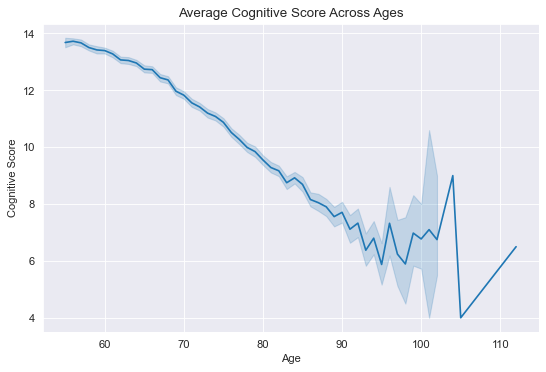

In [9]:
# Age is given to many decimal places so in the code block below we round it to the nearest whole number so we can aggregate.
sns.lineplot(d_cleaned, x = d_cleaned['age'].round(), y = 'cogscore', estimator = 'mean')

plt.xlabel('Age')
plt.ylabel('Cognitive Score')
plt.title('Average Cognitive Score Across Ages')

We want to generally explore the correlation between variables. In order to do so we drop the categorical non-ordinal (i.e. the *order* in the numbers does not represent anything) from the data frame, because in these cases the correlation number is not indicative of anything. The code below produces a heatmap, with the value in each square being the correlation between the two corresponding variables. This helps us confirm that all the variables we have chosen to retain seem to be important to predict the cognitive score of a person, with the possible exceptions of *female, bmi* and *smoking*. Nevertheless we choose to keep them due to the importance given to them in Livingston et al. (2020) and Livingston et al. (2017). 

<Axes: >

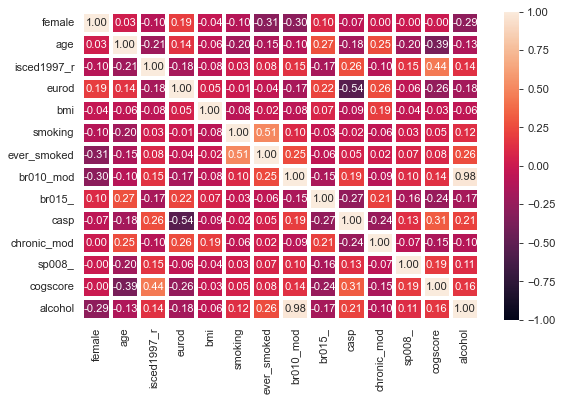

In [10]:
d_cleaned_numeric = d_cleaned.drop(columns = ['mergeid', 'country_mod'])
sns.heatmap(d_cleaned_numeric.corr(), annot=True, fmt='.2f', linewidth = 2, vmin =-1)

We are not pulling any more data from the larger *easySHARE* csv file so we can drop the *mergeid* column because it is clearly not relevant when prediciting *cogscore*.

In addition, we see from Livingston et al. (2020) that the gender of a person is not predictive of their cognitive score. Furthermore, from our heatmap above we can see that the correlation between *cogscore* and the *female* column is 0.00, so we also drop the female column.

In [11]:
d_cleaned = d_cleaned.drop(columns = ['mergeid', 'female'])

The code block below produces three histograms. The one on the left shows the distribution of the age of the people in the data frame. As we can see, the youngest person is about 55. In addition, we can see that, as age increases, there are fewer and fewer people.

The plot in the middle how the distribution of the cognitive score. It is approximately a bell curve centred around 12-13 points. This is perhaps somewhat surprising, because with the very small number of older people in the database, we might expect the distribution to be somewhat left skewed as there should be few people with a very small *cogscore*, given its relationship to the age of the person.

Finally, the last plot shows the distribution of drinking frequency (using the *alcohol* column) coloured by whether the person is currently smoking or not. We see that a large proportion of people do not drink at all, but also that large numbers of people drink "once or twice a week" (corresponding to number 4) and "almost every day" (corresponding to number 7). In addition, a much higher proportion of those drinking almost every day were also smoking at the time of the interview than those who did not drink. 

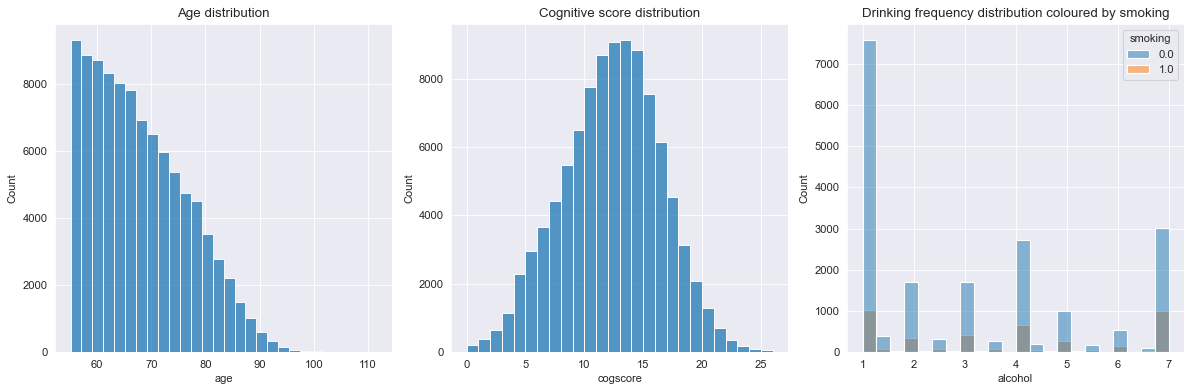

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey='none')

sns.histplot(ax = axes[0], data = d_cleaned, x = 'age', binwidth = 2)
axes[0].set_title('Age distribution')
sns.histplot(ax = axes[1], data = d_cleaned, x = 'cogscore', binwidth = 1)
axes[1].set_title('Cognitive score distribution')
sns.histplot(ax = axes[2], data = d_cleaned, x = 'alcohol', hue = 'smoking')
axes[2].set_title('Drinking frequency distribution coloured by smoking')
plt.tight_layout()

In [13]:
d_cleaned.head()

,country_mod,age,isced1997_r,eurod,bmi,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,cogscore,alcohol
0,40.0,59.700001,5.0,1.0,24.023809,0.0,0.0,5.0,1.0,44.0,1.0,0.0,8.0,NaN
3,40.0,72.599998,5.0,3.0,29.065928,1.0,1.0,2.0,1.0,35.0,6.0,1.0,14.5,NaN
8,40.0,59.599998,3.0,2.0,21.410946,0.0,1.0,7.0,2.0,43.0,1.0,0.0,18.5,NaN
13,40.0,59.799999,4.0,1.0,23.198315,1.0,1.0,7.0,3.0,47.0,1.0,NaN,24.0,NaN
18,40.0,61.299999,3.0,2.0,23.722811,0.0,1.0,4.0,3.0,43.0,0.0,0.0,20.0,4.0


In [14]:
d_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97372 entries, 0 to 301335
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country_mod  97372 non-null  float64
 1   age          97372 non-null  float64
 2   isced1997_r  97372 non-null  float64
 3   eurod        95838 non-null  float64
 4   bmi          94686 non-null  float64
 5   smoking      96887 non-null  float64
 6   ever_smoked  97116 non-null  float64
 7   br010_mod    79210 non-null  float64
 8   br015_       97113 non-null  float64
 9   casp         84065 non-null  float64
 10  chronic_mod  97283 non-null  float64
 11  sp008_       83175 non-null  float64
 12  cogscore     97372 non-null  float64
 13  alcohol      23926 non-null  float64
dtypes: float64(14)
memory usage: 11.1 MB


In [15]:
d_cleaned.isna().sum()

country_mod        0
age                0
isced1997_r        0
eurod           1534
bmi             2686
smoking          485
ever_smoked      256
br010_mod      18162
br015_           259
casp           13307
chronic_mod       89
sp008_         14197
cogscore           0
alcohol        73446
dtype: int64

As we can see, there is a relatively small number of individuals with "na" in the `smoking`, `ever_smoked`, `br015_` and `chronic_mod` variables.  We have decided to drop these individuals from the dataset.

In [16]:
d_cleaned = d_cleaned.dropna(subset=['smoking'])
d_cleaned = d_cleaned.dropna(subset=['ever_smoked'])
d_cleaned = d_cleaned.dropna(subset=['br015_'])
d_cleaned = d_cleaned.dropna(subset=['chronic_mod'])

In [17]:
d_cleaned.isna().sum()

country_mod        0
age                0
isced1997_r        0
eurod           1484
bmi             2630
smoking            0
ever_smoked        0
br010_mod      17645
br015_             0
casp           13239
chronic_mod        0
sp008_         14172
cogscore           0
alcohol        72865
dtype: int64

In [18]:
features = list(d_cleaned.columns)

In order to handle the large number of missing values from `eurod`, `bmi`, `br010_mod`, `casp`, `sp008_`, and `alcohol` variables, we will impute the data.  We do this in different ways, depending on the data type of the variable.  For `bmi`, we simply take the median from all data.  For `eurod`, `br010_mod`, `casp`, we ...

In [19]:
num_imputer = SimpleImputer(strategy="median")

num_cols_imputer = ColumnTransformer(
    # apply the `num_imputer` to all columns apart from the last
    [("num", num_imputer, list(range(d_cleaned.shape[1] - 1)))],
    # don't touch all other columns, instead concatenate it on the end of the
    # changed data.
    remainder = "passthrough"
)

dimp = num_imputer.fit_transform(d_cleaned)

In [20]:
print(dimp)

[[ 40.          59.70000076   5.         ...   0.           8.
    3.        ]
 [ 40.          72.59999847   5.         ...   1.          14.5
    3.        ]
 [ 40.          59.59999847   3.         ...   0.          18.5
    3.        ]
 ...
 [703.          61.79999924   3.         ...   0.          13.5
    3.        ]
 [703.          64.59999847   3.         ...   0.          13.5
    3.        ]
 [703.          58.29999924   3.         ...   0.          16.5
    3.        ]]


In [21]:
df = pd.DataFrame(dimp, columns=features)

In [22]:
rng = np.random.seed(0)

In [23]:
train_set, test_set = train_test_split(df, train_size = 0.8, random_state = rng)

In [24]:
X_train = train_set.drop(['cogscore'], axis=1)
y_train = train_set.cogscore

In [25]:
X_test = test_set.drop(['cogscore'], axis=1)
y_test = test_set.cogscore

In [26]:
base = LinearRegression().fit(X_train, y_train)

In [27]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [28]:
print(np.c_[np.append(['intercept'],base.feature_names_in_),np.round(get_coefs(base),4)])

[['intercept' 16.7732]
 ['country_mod' -0.0009]
 ['age' -0.1262]
 ['isced1997_r' 0.8956]
 ['eurod' -0.1708]
 ['bmi' -0.0045]
 ['smoking' -0.2286]
 ['ever_smoked' 0.0422]
 ['br010_mod' 0.0302]
 ['br015_' -0.1836]
 ['casp' 0.069]
 ['chronic_mod' 0.0162]
 ['sp008_' 0.4712]
 ['alcohol' 0.0137]]


In [29]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

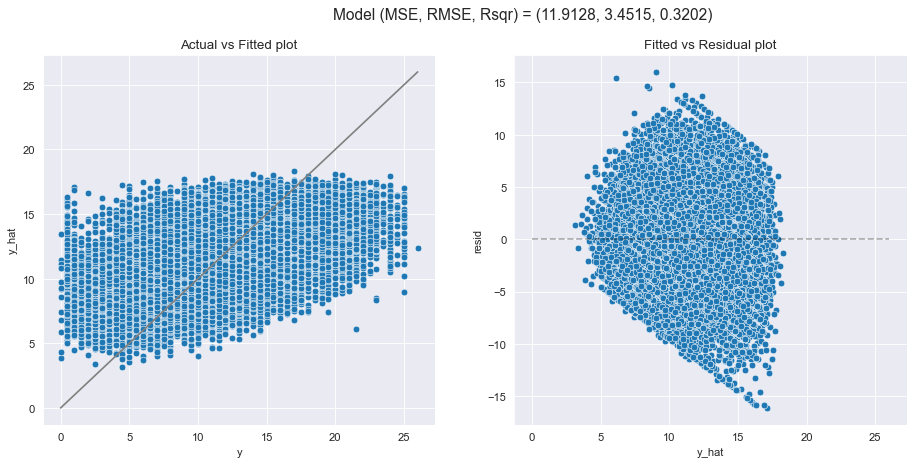

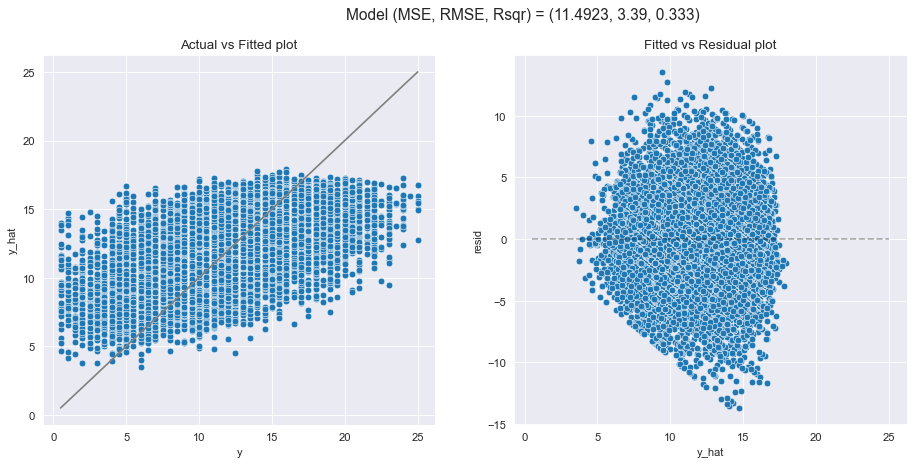

In [30]:
basemetrics_train = model_fit(base, X_train, y_train, plot=True)
basemetrics_test = model_fit(base, X_test, y_test, plot=True)

In [31]:
base_s = make_pipeline(
    StandardScaler(),
    LinearRegression()
).fit(X_train, y_train)

In [32]:
print(np.c_[np.append(['intercept'],base_s.feature_names_in_),np.round(get_coefs(base_s),4)])

[['intercept' 11.988]
 ['country_mod' -0.205]
 ['age' -1.1163]
 ['isced1997_r' 1.3371]
 ['eurod' -0.3927]
 ['bmi' -0.0204]
 ['smoking' -0.0849]
 ['ever_smoked' 0.0209]
 ['br010_mod' 0.0614]
 ['br015_' -0.2431]
 ['casp' 0.414]
 ['chronic_mod' 0.0205]
 ['sp008_' 0.1946]
 ['alcohol' 0.0152]]


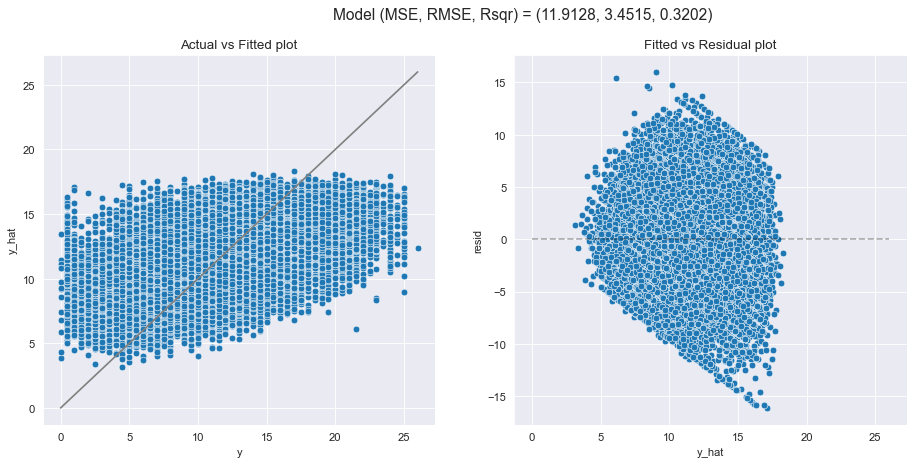

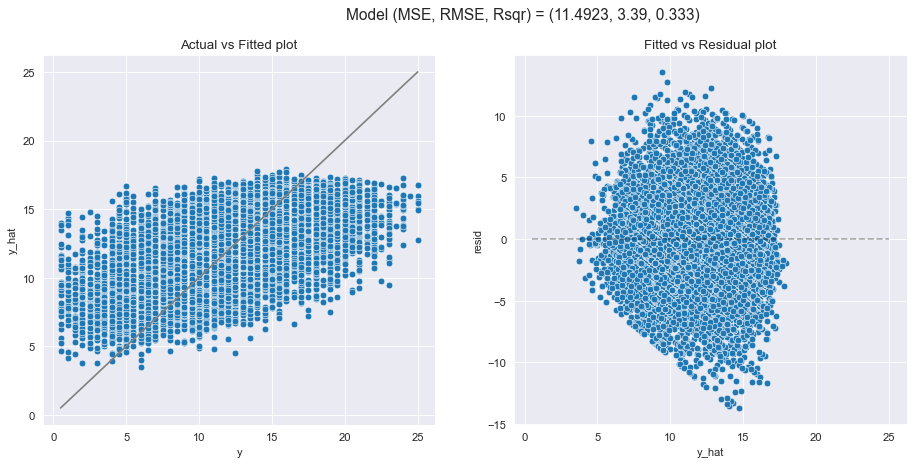

In [33]:
base_s_metrics_train = model_fit(base_s, X_train, y_train, plot=True)
base_s_metrics_test = model_fit(base_s, X_test, y_test, plot=True)

[['intercept' 11.988]
 ['country_mod' -0.205]
 ['age' -1.1163]
 ['isced1997_r' 1.3371]
 ['eurod' -0.3927]
 ['bmi' -0.0204]
 ['smoking' -0.0849]
 ['ever_smoked' 0.0209]
 ['br010_mod' 0.0614]
 ['br015_' -0.2431]
 ['casp' 0.414]
 ['chronic_mod' 0.0205]
 ['sp008_' 0.1946]
 ['alcohol' 0.0152]]


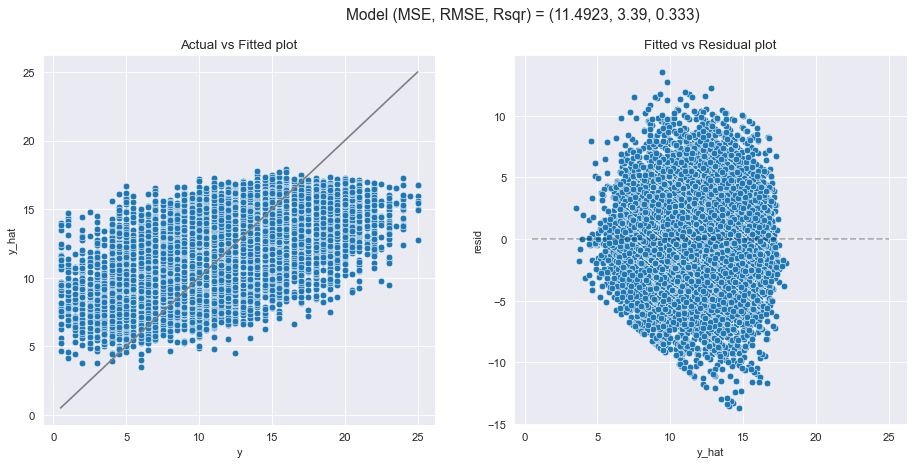

(11.4923, 3.39, 0.333)

In [34]:
alpha = 1

r = make_pipeline(
    StandardScaler(),
    Ridge(alpha = alpha)
).fit(X_train, y_train)

print(np.c_[np.append(['intercept'],r.feature_names_in_),np.round(get_coefs(r),4)])

model_fit(r, X_test, y_test, plot = True)

In [35]:
numeric_variables = ['bmi', 'eurod', 'isced1997_r', 'br015_', 'casp', 'chronic_mod', 'alcohol', 'age', 'br010_mod']

# Define the transformers
ohcenc = OneHotEncoder(handle_unknown='ignore')
num_transformer = Pipeline([("num_scale", StandardScaler())])

# Specify the columns to be transformed by each transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_nonord', ohcenc, ['country_mod']),
        ('num_scale', num_transformer, numeric_variables)
    ],
    remainder='passthrough'  # If there are other columns not specified, they will be passed through
)

# Create the final pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor)])

In [36]:
pablo = make_pipeline(
    preprocessor,
    LinearRegression()
).fit(X_train, y_train)

In [37]:
coefs = get_coefs(pablo.named_steps['linearregression'])
feature_names = pablo.named_steps['columntransformer'].get_feature_names_out()
print(np.c_[np.append(['intercept'],feature_names),np.round(coefs)])

[['intercept' 1410202361.0]
 ['cat_nonord__country_mod_40.0' -1410202348.0]
 ['cat_nonord__country_mod_56.0' -1410202349.0]
 ['cat_nonord__country_mod_100.0' -1410202348.0]
 ['cat_nonord__country_mod_191.0' -1410202348.0]
 ['cat_nonord__country_mod_196.0' -1410202349.0]
 ['cat_nonord__country_mod_203.0' -1410202348.0]
 ['cat_nonord__country_mod_208.0' -1410202349.0]
 ['cat_nonord__country_mod_233.0' -1410202349.0]
 ['cat_nonord__country_mod_246.0' -1410202348.0]
 ['cat_nonord__country_mod_250.0' -1410202349.0]
 ['cat_nonord__country_mod_276.0' -1410202349.0]
 ['cat_nonord__country_mod_300.0' -1410202348.0]
 ['cat_nonord__country_mod_348.0' -1410202348.0]
 ['cat_nonord__country_mod_372.0' -1410202349.0]
 ['cat_nonord__country_mod_376.0' -1410202350.0]
 ['cat_nonord__country_mod_380.0' -1410202349.0]
 ['cat_nonord__country_mod_428.0' -1410202349.0]
 ['cat_nonord__country_mod_440.0' -1410202350.0]
 ['cat_nonord__country_mod_442.0' -1410202348.0]
 ['cat_nonord__country_mod_470.0' -14102023

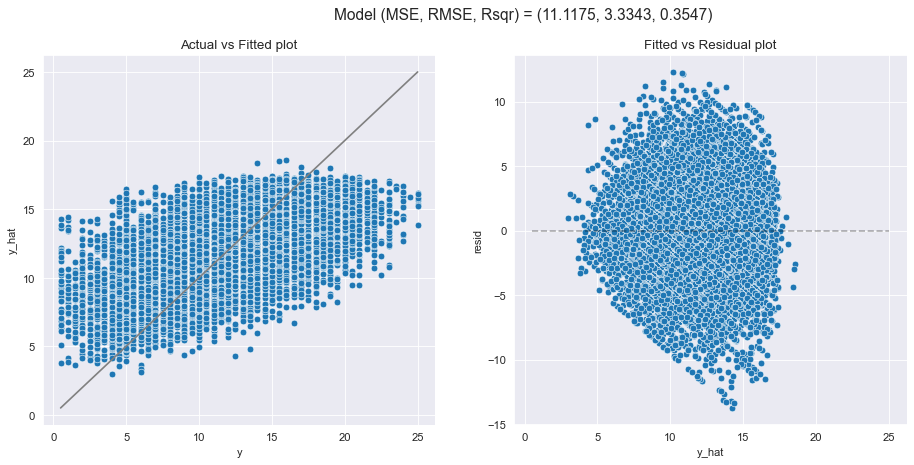

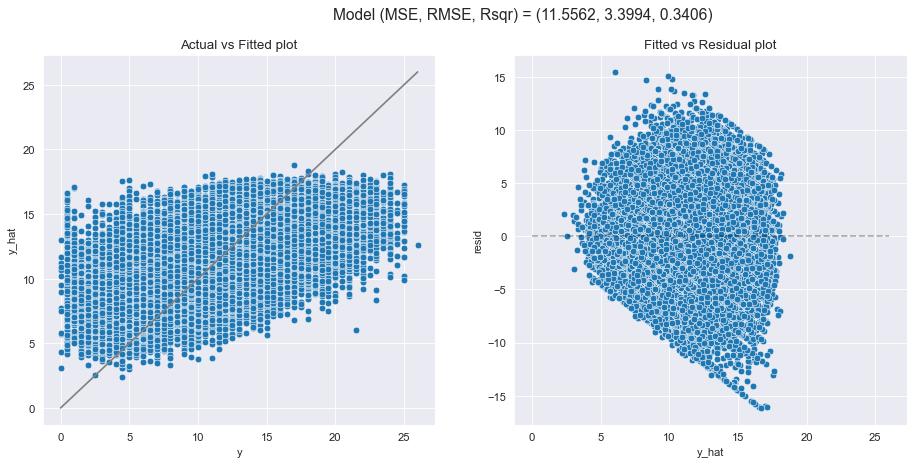

(11.5562, 3.3994, 0.3406)

In [38]:
model_fit(pablo, X_test, y_test, plot = True)
model_fit(pablo, X_train, y_train, plot = True)

In [39]:
alphas = np.logspace(-2, 6, 200)

ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        preprocessor,
        Ridge(alpha=a)
    ).fit(X_train, y_train)
    
    ws.append(m[1].coef_) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test)))

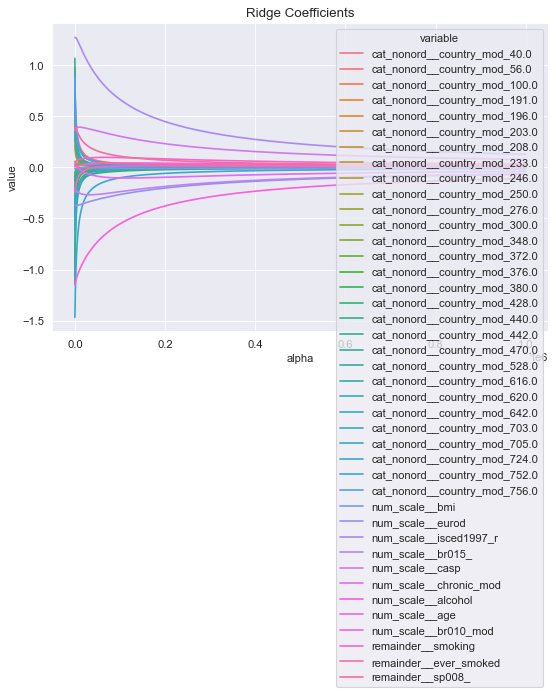

In [40]:
# Create a data frame for plotting
sol_path = pd.DataFrame(
    data = ws,
    columns = pablo.named_steps['columntransformer'].get_feature_names_out() # these r just column names so is ok
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.set_title("Ridge Coefficients")
plt.show()

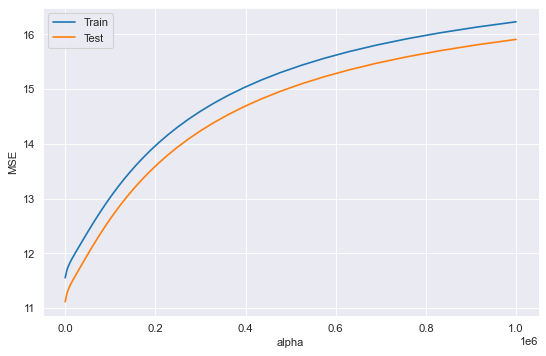

In [41]:
mses_path = pd.DataFrame(
    {'alpha': alphas, 'Train': np.asarray(mses_train), 'Test': np.asarray(mses_test)}).melt(
    id_vars = ('alpha')
)


ax = sns.lineplot(x='alpha', y='value', hue='variable', data=mses_path)
ax.set_ylabel("MSE")
# To remove legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
plt.show()

In [42]:
alphas[np.argmin(np.asarray(mses_test))-1]

16.446761779946645

In [43]:
# Grid of tuning parameters
alphas = np.linspace(0, 15, num=151)  

#Pipeline
m = make_pipeline(
        preprocessor,
        Ridge())

# CV strategy
cv = KFold(5, shuffle=True, random_state=rng)

# Grid search
gs = GridSearchCV(m,
    param_grid={'ridge__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")
gs.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.59957e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.57339e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.71178e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.27304e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_nonord',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['country_mod']),
                                                                        ('num_scale',
                                                                         Pipeline(steps=[('num_scale',
                                                                                          StandardScaler())]),
                                                                         ['bmi',
                                                                          'eurod',
                                                                          'isced1997_r',
                                                                          'br015_',
                                                                          'casp',
                                                                          'chro...
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. ])},
             scoring='neg_mean_squared_error')

In [44]:
print(gs.best_params_)
print(-gs.best_score_)

{'ridge__alpha': 15.0}
11.568550833949002


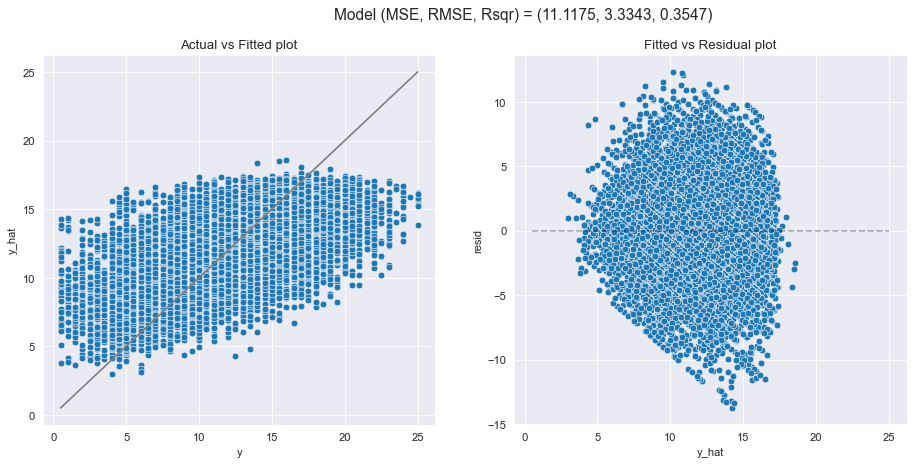

(11.1175, 3.3343, 0.3547)

In [45]:
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

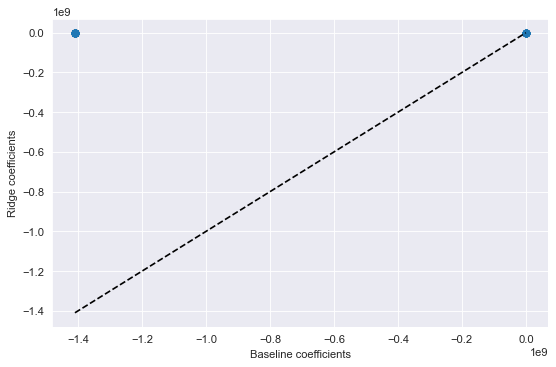

In [46]:
fig, ax = plt.subplots(1,1)

ax.scatter(pablo[1].coef_, gs.best_estimator_[1].coef_)
x1 = np.min(pablo[1].coef_)
x2 = np.max(pablo[1].coef_)
ax.plot([x1,x2],[x1,x2],color='k',linestyle="dashed")
ax.set_xlabel('Baseline coefficients')
ax.set_ylabel('Ridge coefficients')
plt.show()

In [47]:
print('l2 norm of baseline coeffcients',np.linalg.norm(pablo[1].coef_))
print('l2 norm of ridge coeffcients',np.linalg.norm(gs.best_estimator_[1].coef_))

l2 norm of baseline coeffcients 7594172059.57826
l2 norm of ridge coeffcients 3.9956406801457747


In [48]:
cv_mse = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_mse.update(
    # Convert negative mses to positive
    -1 * cv_mse.filter(regex = '_test_score')
)

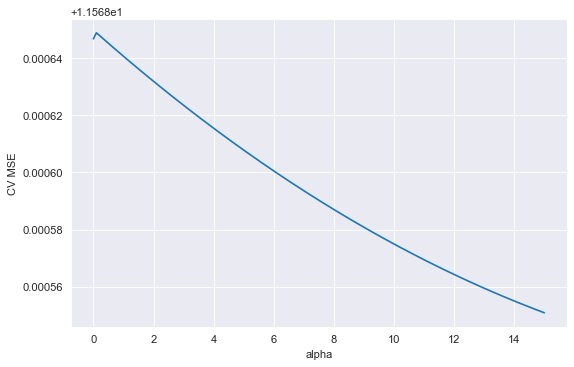

In [49]:
ax = sns.lineplot(x='alpha', y='mean_test_score', data=cv_mse)
ax.set_ylabel('CV MSE')
plt.show()

In [50]:
lazo_alphas = np.logspace(-2, 1, 200)
lazo_ws = [] # Store coefficients
lazo_mses_train = [] # Store training mses
lazo_mses_test = [] # Store test mses

KBest = SelectKBest(f_regression, k = 16)

for a in lazo_alphas:
    m = make_pipeline(
        preprocessor,
        Lasso(alpha=a)
    ).fit(X_train, y_train)
    
    lazo_ws.append(m[1].coef_) 
    lazo_mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    lazo_mses_test.append(mean_squared_error(y_test, m.predict(X_test)))

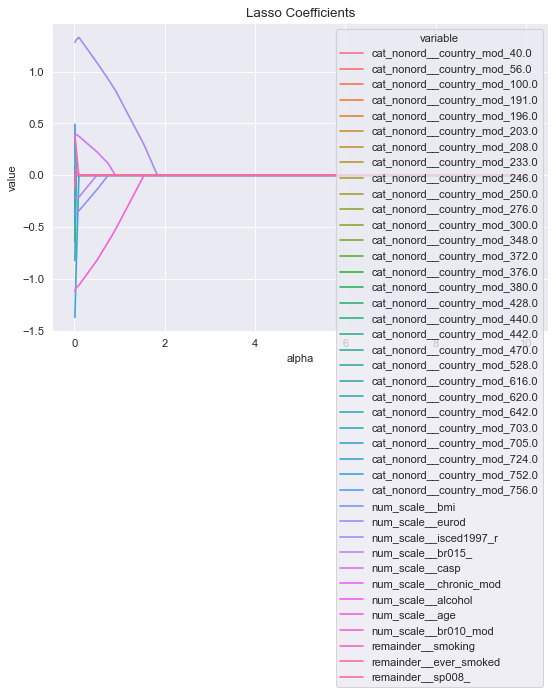

In [51]:

# Create a data frame for plotting
sol_path_lazo = pd.DataFrame(
    data = lazo_ws,
    columns = pablo.named_steps['columntransformer'].get_feature_names_out()
).assign(
    alpha = lazo_alphas,
).melt(
    id_vars = ('alpha')
)


ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path_lazo)
ax.set_title("Lasso Coefficients")
plt.show()

In [52]:
KBest = SelectKBest(f_regression, k = 10)

KBestmod = make_pipeline(
    preprocessor,
    KBest,
).fit(X_train, y_train)

ind = KBestmod.named_steps['selectkbest'].get_support(indices = True)

kbestfts = []

for i in ind:
    new = feature_names[i]
    kbestfts.append(new)
    
print(kbestfts)

['cat_nonord__country_mod_380.0', 'cat_nonord__country_mod_724.0', 'num_scale__eurod', 'num_scale__isced1997_r', 'num_scale__br015_', 'num_scale__casp', 'num_scale__chronic_mod', 'num_scale__age', 'num_scale__br010_mod', 'remainder__sp008_']


In the code chunk below we split the data frame into a train set and a test set. Because we have dealt with the class imbalance in the *chronic_mod* column there is no need to stratify by any variable. We also chose *cogscore* to be the respone variable because this is obviously what we are trying to predict.

We adapt the MultiHotEncoder class defined in this [Stack Exchange post](https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer#:~:text=To%20make%20a%20ColumnTransformer%20compatible,DataFrame%20input.) to enable us to use the MultiLabelBinarizer class within the context of ColumnTransformer. We need this because right now the *country_mod* class is a categorical non-ordinal variable and therefore needs to be encoded in such a manner.

The binary categorical variables need not be encoded, as we did this previously with *smoking, ever_smoked* and *sp008_*. In addition, *female* has already been encoded for us, because as we saw previously the only values the variable takes in our data frame are 1 and 0.

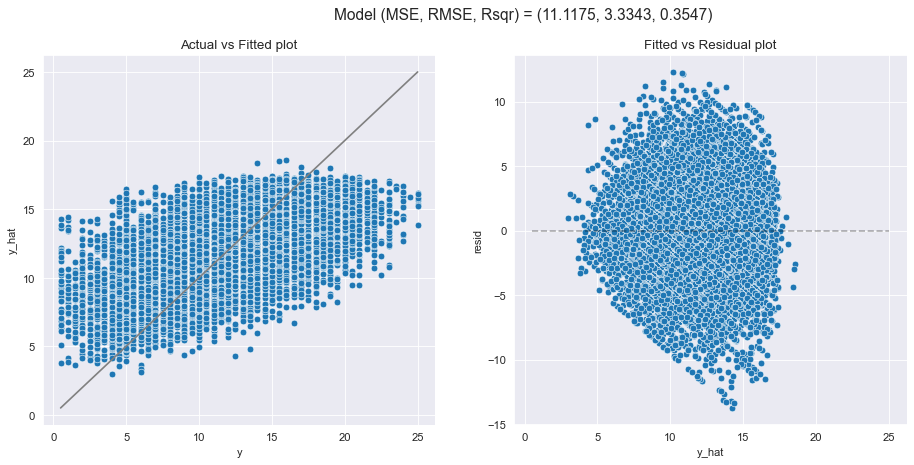

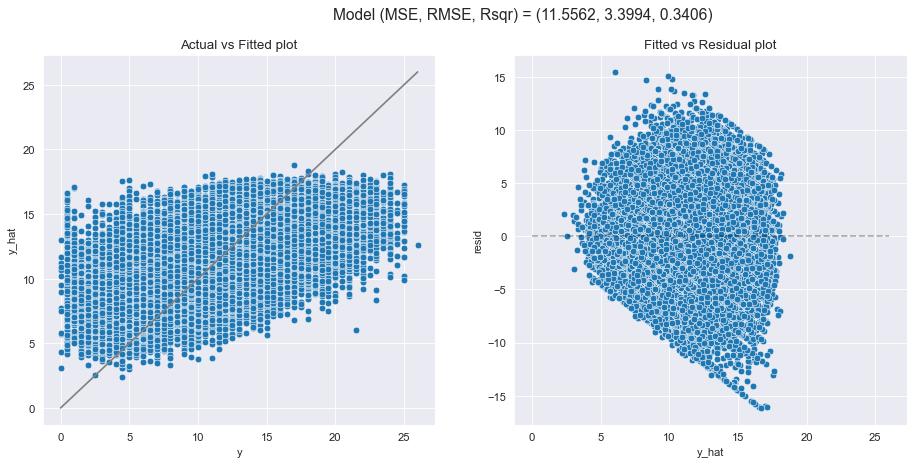

(11.5562, 3.3994, 0.3406)

In [53]:
d_cleaned_new = d_cleaned.drop(columns = ['country_mod'])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num_scale', num_transformer, numeric_variables)
    ],
    remainder='passthrough'  # If there are other columns not specified, they will be passed through
)

mary = make_pipeline(
    preprocessor,
    LinearRegression()
).fit(X_train, y_train)


model_fit(mary, X_test, y_test, plot = True)
model_fit(mary, X_train, y_train, plot = True)

# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

*Include references if any*

In [57]:
# Run the following to render to PDF

!jupyter nbconvert --to pdf project1_v4.ipynb

[NbConvertApp] Converting notebook project1_v4.ipynb to pdf
[NbConvertApp] Support files will be in project1_v4_files/
[NbConvertApp] Making directory ./project1_v4_files
[NbConvertApp] Writing 105762 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2000689 bytes to project1_v4.pdf
